#Finding documents with similar content and topics using LSA

In [7]:
from docx import *
import re, glob, os
import numpy as np
import scipy as sp
from bs4 import BeautifulSoup
import zipfile
import sklearn
import tempfile

import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import ward, dendrogram
from IPython.display import display, HTML

In [2]:
%pylab -- inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## Code to extract text from docx

In [12]:
#returns all the text except the header info 'TEKS302A-th001'
def getText(docpath):
    text = ''
    try:
        doc = Document(docpath)
        for par in doc.paragraphs[1:]:
            style = par.style
            #text += '' + par.text
            for run in par.runs:
                if not run.strike:
                    for t in run._r.t_lst:
                        if t.text is None:
                            pass
                        else:
                            text += '' + t.text    #why add white spaces?
            text = text.replace(u'\u2019',"'")
            text = text.encode('ascii','ignore')
            text = re.sub('^ ','',text)
            text = text + ' ' #insert white space after each paragraph to avoid sticking words together
            #text = text.replace(' ', ' ')
    except:
        pass
    return text
#print getText('Sample lesson scripts\\TEKS402A-th001.docx')


#Extracting problem statement text by extracting text in the first 1x1 table in the script
#extracts text outside of tables by calling getText
def getText4(docpath):
    doc = Document(docpath)
    text = ''
    for tab in doc.tables:
        #if len(tab.rows)==1 and len(tab.columns)==1: #1x1 table to exclude other tables
        if len(tab.columns)==1: #1x1 table to exclude other tables
            for row in tab.rows:
                for cell in row.cells:
                    for par in cell.paragraphs:
                        for run in par.runs:
                            if not run.strike:
                                for t in run._r.t_lst:
                                    if t.text is None:
                                        pass
                                    else:
                                        text += ' ' + t.text    #why add white spaces?
                        #text += ' ' + par.text
                        #style = par.style
            break #stop after finding the first 1x1 table
            
    text += getText(docpath) #adding text outside tables
    
    text = text.replace(u'\u2019',"'")
    text = text.encode('ascii','ignore')
    text = re.sub('^ ','',text)
    return text

## Code to process text

In [13]:
def removeBracketed(text):
    '''Remove text enclosed in square brackets.  Regexes can't really handle
    nested brackets, so this does it manually.'''
    bc = 0
    temp = ''
    for char in text:
        if char == '[':
            bc += 1
        if bc == 0: temp += char
        if char == ']':
            bc -= 1
    return temp

#removes all punctuations
def remove_punc(text):
    punc = '!@#$%^&*()_-+={}[]:;"\'|<>,.?/~`'
    for char in punc:
        text = text.replace(char, ' ')
        text = text.replace('  ', ' ')
    return text

#removes digits
def remove_digits(text):
    digits = '0123456789'
    for char in digits:
        text = text.replace(char, '')
        text = text.replace('  ', ' ')
    return text

In [14]:
def clean_text(text):
    text = text.lower()
    text = removeBracketed(text)
    text = remove_punc(text)
    text = remove_digits(text)
    return text

## Building a corpus

In [15]:
#returns the paths of theory and problem scripts in a lesson folder
#lessonpath is the lesson's folder path
#for example: lessonpath = 'C:/Users/eabalo/Documents/STAAR2014/3g/308A/'

def scriptpaths(lessonpath):
    #paths of docx files needed to create corpus
    paths = []

    for i in glob.glob(lessonpath + 'Scripts/*.docx'): #append theory scripts
        if '~' in i: #ignore corrupted files
            pass
        else:
            paths.append(i)
        
    for i in glob.glob(lessonpath + 'Problems/*.docx'): #append problem scripts
        if '~' in i: #ignore corrupted files
            pass
        else:
            paths.append(i)
    return paths

## Creating corpus

In [19]:
#creates a folder with text files built from text extracted from theory and problem scripts in a given lesson
#input: lesson path in SVN folder; for example 
    #lessonpath = 'C:/Users/eabalo/Documents/STAAR2014/3g/308B/'
#output: named files containing text extracted from corresponding docx file
#calls scriptpaths(), getText4(), clean_text()

def corpusText(lessonpath):
    #corpus path to store processed txt files
    corpuspath = 'C:/Users/eabalo/Desktop/STAAR35Analyses/data/corpus/'

    #lesson number
    lesson = lessonpath.split('/')[-2]

    #path for folder of corpus (txt files)
    newpath = corpuspath + lesson + '/'

    #create folder
    if not os.path.exists(newpath): 
        os.makedirs(newpath)
    
    #paths of docx files in SVN folder (theory and problem) 
    filepaths = scriptpaths(lessonpath)

    #creating corpus of text from lesson scripts
    #extracting text from docx files
    for i in filepaths:
        textfilename = i.split('\\')[-1].replace('docx', 'txt')
        text = getText4(i)
        text = clean_text(text)
        with open(newpath + textfilename, 'wb') as f:
            f.write(text)

## Test on Lesson 405B

In [30]:
lessonpath = 'C:/Users/eabalo/Documents/STAAR2014/4g/405B/'

#lesson number
lessonname = lessonpath.split('/')[-2]

#creating corpus of txt files
corpusText(lessonpath)

In [31]:
corpuspath = 'C:/Users/eabalo/Desktop/STAAR35Analyses/data/corpus'

filepaths = glob.glob(corpuspath + '/'+ lessonname + '/*.txt')

#script names
docindex = [w.split('-')[-1].split('.')[0] for w in filepaths]

#building a document-term matrix
vectorizer = CountVectorizer(input = 'filename')

dtm = vectorizer.fit_transform(filepaths)

#lexicon of words in lesson
vocab = vectorizer.get_feature_names()

#converting to numpy arrays
dtm = dtm.toarray()

vocab = np.array(vocab)

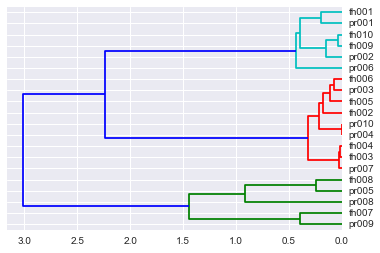

In [32]:
#Latent semantic analysis

#SVD
Umat, Smat, Vmat = np.linalg.svd(dtm)

#Reduction to subspace of dimension 3
ndim = 3

#'Re-construction' of document-term matrix using reduced SVD matrices
Smatd = np.zeros((ndim, ndim), dtype = complex)
Smatd[:ndim, :ndim] = np.diag(Smat)[:ndim, :ndim]

Vmatd = Vmat[:ndim,:]
Umatd = Umat[:,:ndim]

dtm = np.dot(Umatd, np.dot(Smatd, Vmatd))

#distance metric based on cosine similarity
dist = 1 - cosine_similarity(dtm)

np.round(dist, 2)

#linkage matrix
linkage_matrix = ward(dist)

#dendrogram
dendrogram(linkage_matrix, orientation='right', labels = docindex);

Some observations about LSA's accuracy:

- Problem item 4 (**pr004**) and problem item 10 (**pr010**) are indeed similar. They are multiple choice problems that ask students to pick a table corresponding to a given number sentence.

- Theory item 3 (**th003**) and theory item 4 (**th004**) are similar. Both introduce students to the task of matching a number sentence with a table. However in theory item 3, we gradually show how a number sentence matches one single table. In theory item 4, we increase the complexity, and generalize it to matching a number sentence to one out of four tables. Problem item 7 (**pr007**) is similar to  theory items 3 and 4 because it also asks students to select a table that matches a given number sentence, but it is not clear that it is a better match that another problem of the same type.

- Theory items 9 (**th009**) and 10 (**th010**) are indeed similar. Theory item 10 is a continuation of the content shown in theory item 9.

- Theory items 5 (**th005**) and 6 (**th006**) show students how to match a number sentence to one out of four tables. The tables are 'vertical' (5 rows by 2 columns) and the number sentence involves the operation of division. In fact, theory item 6 is a continuation of theory item 5, so this is clear match. It is interesting to observe that problem item 3 (**pr003**) follows right after theory item 6 in the lesson and it also has a number sentence with a division and tables given as answer choices with 5 rows and 2 columns each. LSA made a great match.

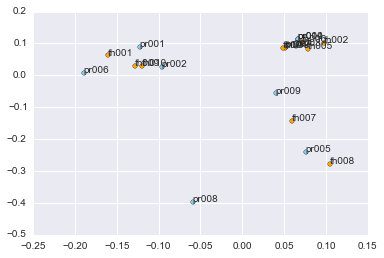

In [33]:
#document names
docindex = [w.split('-')[-1].split('.')[0] for w in filepaths]

#multi-dimensional scaling
mds = MDS(n_components=2, dissimilarity = 'precomputed', random_state = 1)

pos = mds.fit_transform(dist)

xs, ys = pos[:, 0], pos[:, 1]

for x, y, name in zip(xs, ys, docindex):
    color = 'orange' if 'th' in name else 'skyblue'
    scatter(x, y, c=color)
    plt.text(x, y, name)

##References

- https://en.wikipedia.org/wiki/Latent_semantic_analysis
- http://www.puffinwarellc.com/index.php/news-and-articles/articles/33-latent-semantic-analysis-tutorial.html?start=2
- https://de.dariah.eu/tatom/working_with_text.html